In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
import time
from pathlib import Path
import torch
import concord as ccd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib as mpl
from scipy import sparse
import pickle as pkl

from matplotlib import font_manager, rcParams
custom_rc = {
    'font.family': 'Arial',
}

mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['pdf.fonttype'] = 42

In [ ]:
proj_name = "metrics_integration_methods"

file_suffix = time.strftime('%b%d-%H%M')

save_dir = Path(f"../save/{proj_name}-{file_suffix}")
save_dir.mkdir(parents=True, exist_ok=True)

# load the pickle files

In [120]:
proj_name = "TabulaSapiens_n=300"

In [121]:
# cross_tissue_Eraslan, etc. 
file_path = (
    Path("/Volumes/Shared/Concord_backup/save/results_concord-1.0.6_adjusted_metrics_Jul24")
    / "benchmark_cell_type_summary_updated"
    / f"benchmark_{proj_name}_Jul24-1358.pkl"
)

with open(file_path, "rb") as f:
    bm = pkl.load(f)

In [122]:
combined_df = bm['combined']
# rank the methods by the Aggregate score: Total
combined_df = combined_df.sort_values(by=('Aggregate score', 'Total'), ascending=False)

# save_dir = save_dir / "benchmarks_celltype"

# print(save_dir)
# save_dir.mkdir(parents=True, exist_ok=True)

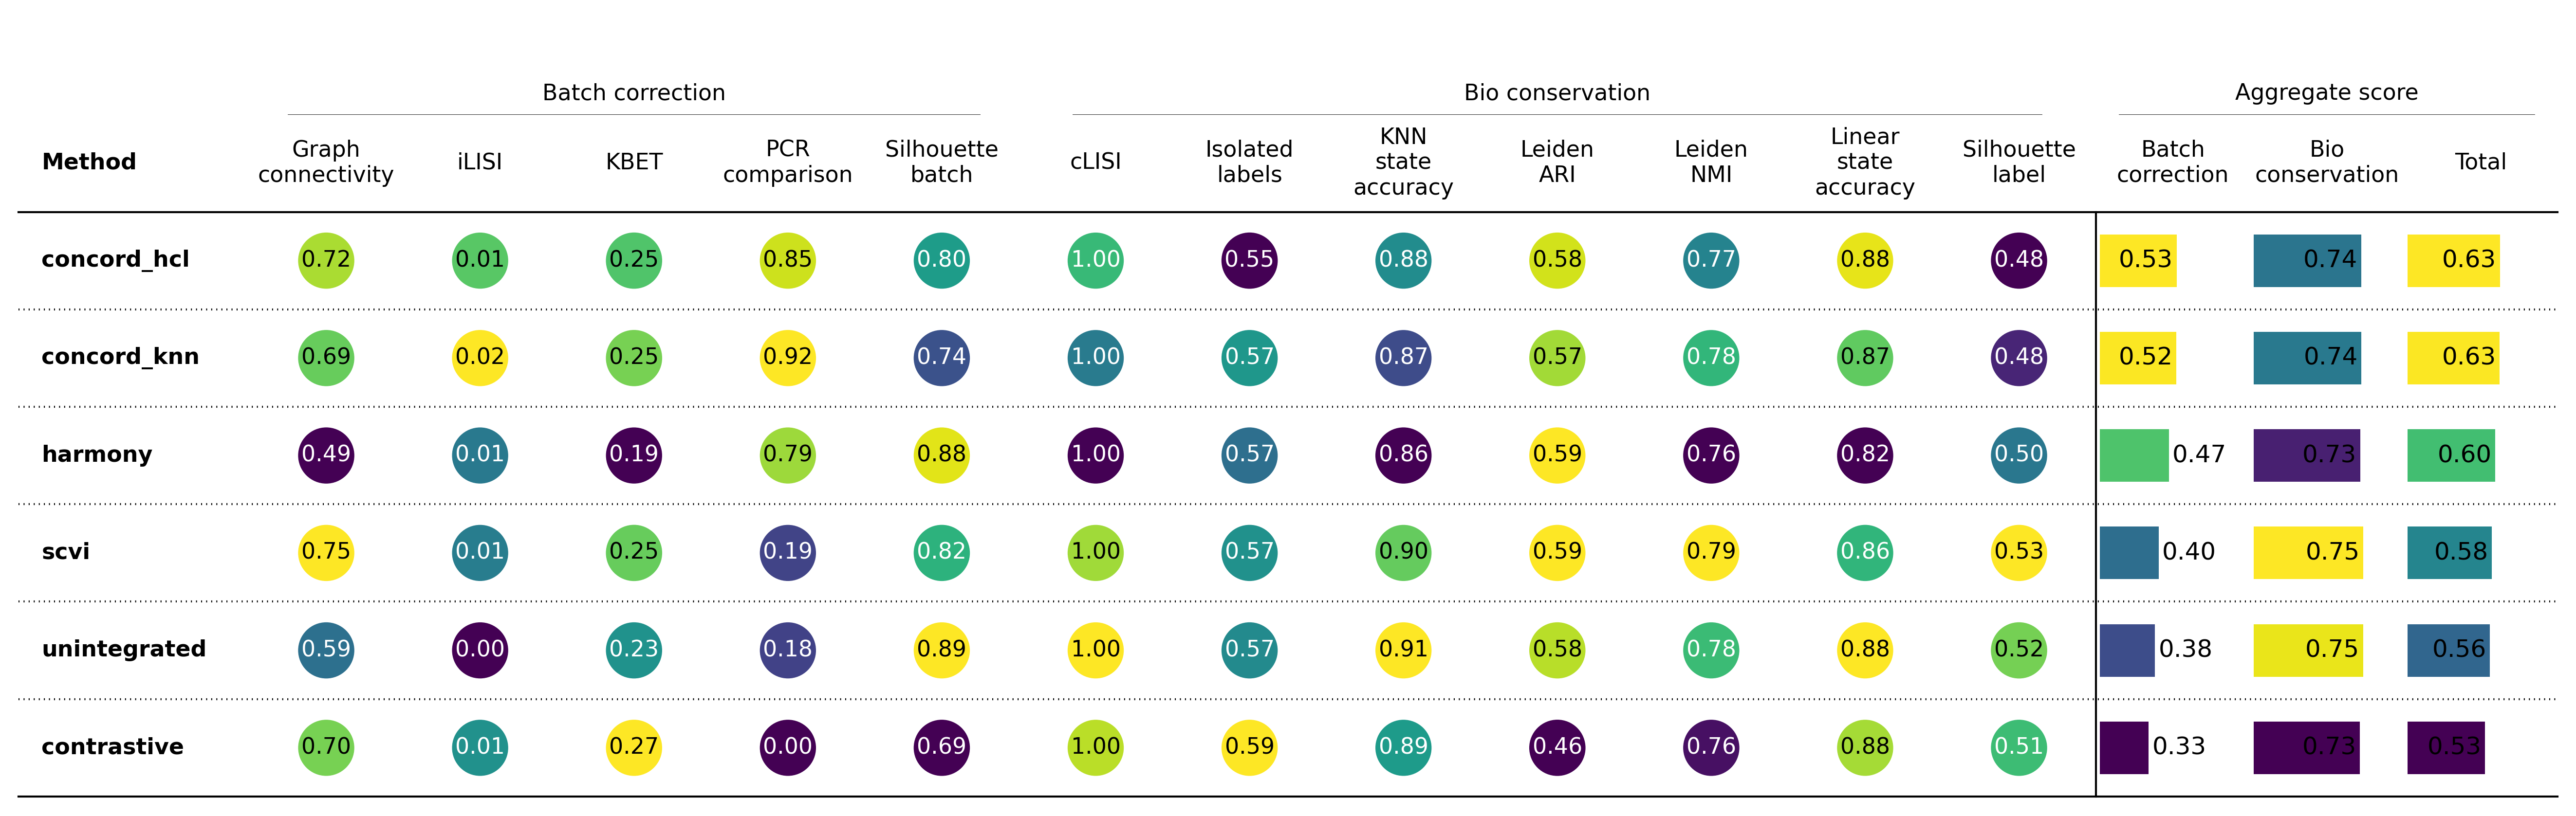

In [123]:
table_plot_kw = dict(
        pal="viridis", pal_agg="viridis", cmap_method="minmax", dpi=300)
ccd.pl.plot_benchmark_table(
    combined_df,
    save_path=save_dir / f"{proj_name}_combined_res_{file_suffix}.pdf",
    agg_name="Aggregate score",
    figsize=(max(8, 1.5 * len(combined_df.columns)), 7),
    **table_plot_kw,

)

# double check

In [125]:
bm['combined']

Batch correction                                     \
             Graph connectivity     iLISI      KBET PCR comparison   
scvi                   0.748229  0.008144  0.252526       0.185673   
harmony                 0.49412  0.007923  0.191273       0.785784   
unintegrated           0.586996  0.001141  0.231526       0.181485   
concord_knn            0.689067  0.017841  0.254628       0.919382   
concord_hcl            0.716303  0.013505  0.248993       0.850982   
contrastive            0.695755  0.009529  0.270972              0   

                              Bio conservation                  \
             Silhouette batch            cLISI Isolated labels   
scvi                 0.816884         0.999947         0.57223   
harmony              0.878509         0.999771        0.566307   
unintegrated         0.887139         0.999977        0.571042   
concord_knn          0.739686         0.999856        0.573378   
concord_hcl          0.797962          0.99991        0.550715   
contrastive          0.690122         0.999956        0.593666   

                                                                             \
             KNN state accuracy Leiden ARI Leiden NMI Linear state accuracy   
scvi                   0.895564     0.5925   0.787403              0.862354   
harmony                0.862491   0.592625   0.758088              0.822635   
unintegrated           0.905749   0.578097   0.778099              0.883377   
concord_knn            0.872302   0.574276   0.777344              0.868657   
concord_hcl            0.883281   0.583254     0.7712              0.881019   
contrastive            0.886079   0.458426   0.759258              0.875193   

                               Aggregate score                             
             Silhouette label Batch correction Bio conservation     Total  
scvi                 0.529604         0.402291         0.748515  0.575403  
harmony              0.497337         0.471522         0.728465  0.599993  
unintegrated         0.518345         0.377657         0.747812  0.562735  
concord_knn          0.481762         0.524121         0.735368  0.629744  
concord_hcl          0.476194         0.525549         0.735082  0.630315  
contrastive          0.512863         0.333276         0.726492  0.529884

In [126]:
bm['combined']['Batch correction'].mean(axis=1)

scvi            0.402291
harmony         0.471522
unintegrated    0.377657
concord_knn     0.524121
concord_hcl     0.525549
contrastive     0.333276
dtype: object

In [127]:
bm['combined']['Bio conservation'].mean(axis=1)

scvi            0.748515
harmony         0.728465
unintegrated    0.747812
concord_knn     0.735368
concord_hcl     0.735082
contrastive     0.726492
dtype: object

In [128]:
(bm['combined']['Batch correction'].mean(axis=1) + bm['combined']['Bio conservation'].mean(axis=1)) / 2

scvi            0.575403
harmony         0.599993
unintegrated    0.562735
concord_knn     0.629744
concord_hcl     0.630315
contrastive     0.529884
dtype: object

# Trial

Order the columns of the benchmark result table to put "KNN state accuracy" and "Linear state accuracy" to the end of the bioconservation columns.

In [151]:
proj_name = "TabulaSapiens_n=300"

file_path = (
    Path("/Volumes/Shared/Concord_backup/save/results_concord-1.0.6_adjusted_metrics_Jul24")
    / "benchmark_cell_type_summary_old"
    / "benchmark_TabulaSapiens_n=300_Jul23-2142.pkl"
)

out = pkl.load(open(file_path, "rb")) 

In [152]:
# ---------- helpers ----------------------------------------------------
def _mean_numeric(df):
    return df.apply(pd.to_numeric, errors="coerce").mean(axis=1, skipna=True)

# ---------- stitch tables together ------------------------------------
combined_df = out['combined']

# ---------- per‑family aggregate means --------------------------------
agg_groups = [g for g in combined_df.columns.get_level_values(0).unique()
            if g != "Aggregate score"]

agg_parts = []
for g in agg_groups:
    if g in ("Geometry", "Topology"):   # these already have per‑block scores
        continue
    s = _mean_numeric(combined_df.xs(g, axis=1, level=0))
    s.name = ("Aggregate score", g)     # give Series the final 2‑level name
    # If s.name is already in combined_df, remove that column
    if s.name in combined_df.columns:
        combined_df = combined_df.drop(columns=[s.name])
    agg_parts.append(s)

if agg_parts:                           # <-- ▸ only concat when we have parts
    agg_df = pd.concat(agg_parts, axis=1)
else:
    agg_df = pd.DataFrame(index=combined_df.index) 

combined_df = pd.concat([combined_df, agg_df], axis=1)

# ---------- overall average (added *after* ordering so it is last) ----
combined_df = combined_df.loc[:, ~combined_df.columns.duplicated()]

# sort columns: Aggregate score last, then by group, then by name
# with special handling to put probe accuracies at the end of Bio conservation
probe_acc_cols = {"KNN state accuracy", "Linear state accuracy"}
combined_df = combined_df.loc[
    :,
    sorted(combined_df.columns,
            key=lambda c: (c[0] == "Aggregate score",
                            c[0],
                            c[1] in probe_acc_cols,
                            str(c[1]).lower()))
]

agg_cols = [col for col in combined_df.columns if col[0] == "Aggregate score"]
combined_df[("Aggregate score", "Average")] = combined_df[agg_cols].apply(pd.to_numeric, errors="coerce").mean(axis=1, skipna=True)

# ---------- ranking ----------------------------------------------------
combined_df = combined_df.sort_values(
    by=("Aggregate score", "Average"), ascending=False
)

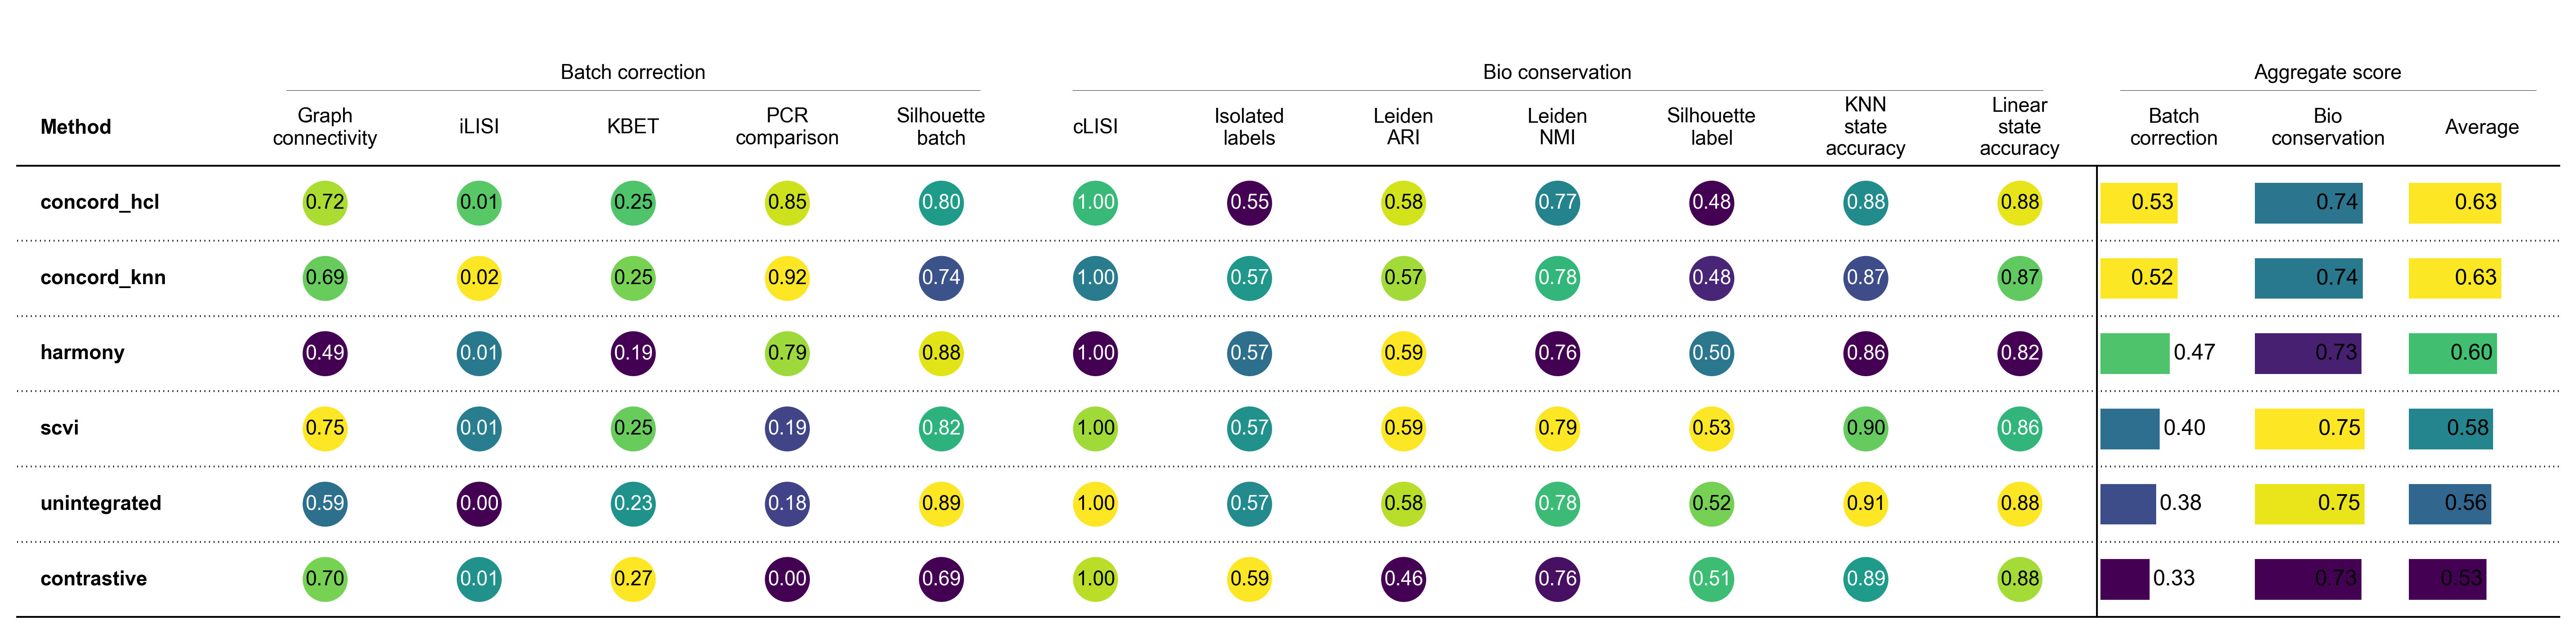

In [153]:
table_plot_kw = dict(
        pal="viridis", pal_agg="viridis", cmap_method="minmax", dpi=300)
with plt.rc_context(rc=custom_rc):
    combined_df = ccd.bm.combine_benchmark_results( # This does the organizing and recomputing scores
        out,
        block_include=("scib", "probe"), # Which stats to be included
        plot=False,
        save_path=save_dir / f"combined_res_{file_suffix}.pdf",
        table_plot_kw=table_plot_kw,
    )
    ccd.bm.plot_benchmark_table(
            combined_df.dropna(axis=0, how='any'),
            save_path=save_dir / f"benchmark_table_{proj_name}_{file_suffix}.svg",
            agg_name="Aggregate score",
            figsize=(25, 6),
            **table_plot_kw
            )